# Encoding

In [84]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution

## Basis Encoding

Basis encoding is one of the most straightforward methods for encoding classical data into a quantum state. In this method, each classical bit string is directly mapped to a corresponding quantum state on a computational basis.

- For a classical binary string `00`, the corresponding quantum state in basis encoding would be $\ket{00}$.
- Similarly, for the binary string `11`, the corresponding quantum state would be  $\ket{11}$ .
- For the character `h` ASCII representation is `0x68` whose quantum state would be $\ket{1101000}$.

In [85]:
def basis_encoder(qc: QuantumCircuit, q: QuantumRegister, bits: np.ndarray):
    for i in range(len(bits)):
        qc.reset(q[i])
        if bits[i] == 1:
            qc.x(q[i])

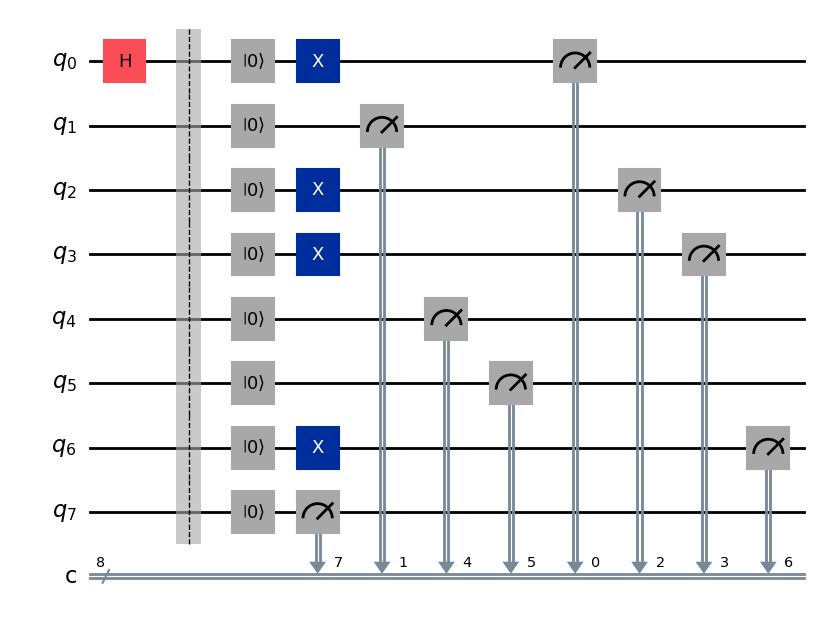

In [86]:
basis = np.array([1, 0, 1, 1, 0, 0, 1, 0])
n = len(basis)
q = QuantumRegister(n, 'q')
c = ClassicalRegister(n, 'c')
qc = QuantumCircuit(q, c)
qc.h(q[0])
qc.barrier()

basis_encoder(qc, q, basis)
qc.measure(q, c)

qc.draw(output='mpl')

> The output seems in opposite order because of the way qubits are ordered in Qiskit. The least significant bit is on the rightmost side.

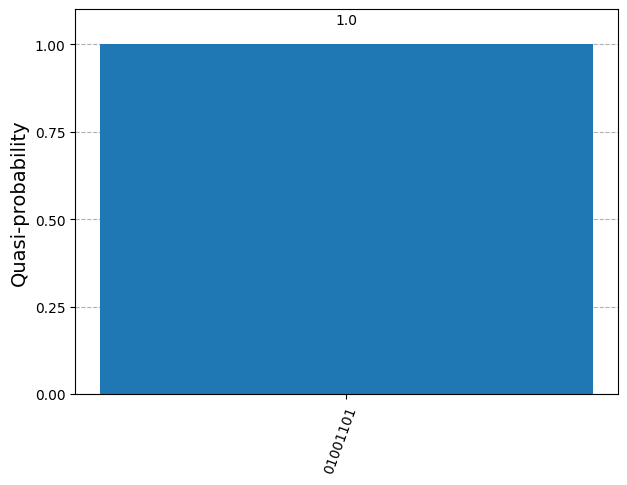

In [87]:
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
compiled_circuit = pass_manager.run(qc)

result = backend.run(compiled_circuit).result()
plot_distribution(result.get_counts())

## Amplitude Encoding

Amplitude encoding is a method of encoding classical data into a quantum state by setting the amplitudes of the quantum state according to the classical data. This encoding method is more efficient than basis encoding as it can encode multiple classical states into a single quantum state. To be more specific, the amplitude encoding of a classical state $x$ is given by the quantum state $\sum_{i} \alpha_i \ket{i}$, where $\alpha_i$ is the amplitude of the state $\ket{i}$.

In [88]:
def amplitude_encoder(qc: QuantumCircuit, q: QuantumRegister, input_state: np.ndarray):
    qc.barrier()
    qc.initialize(input_state, q)

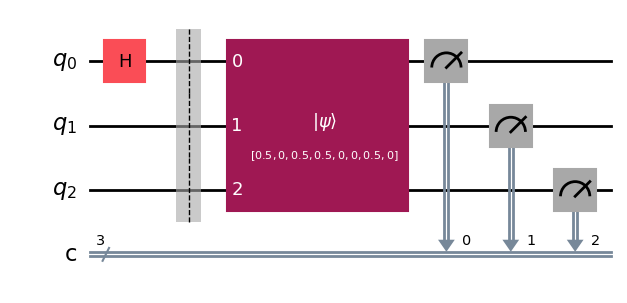

In [89]:
amp = np.array([1, 0, 1, 1, 0, 0, 1, 0]) / np.sqrt(4)

q = QuantumRegister(np.ceil(np.log2(len(amp))), 'q')
c = ClassicalRegister(np.ceil(np.log2(len(amp))), 'c')
qc = QuantumCircuit(q, c)

qc.h(q[0])
amplitude_encoder(qc, q, amp)
qc.measure(q, c)

qc.draw(output='mpl')

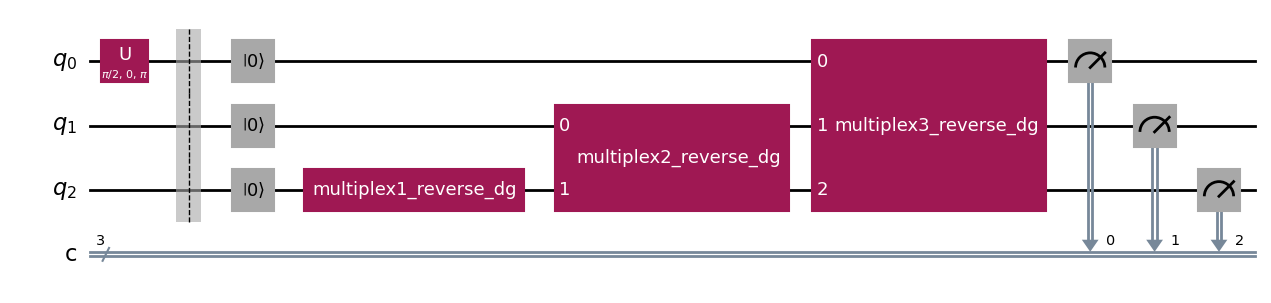

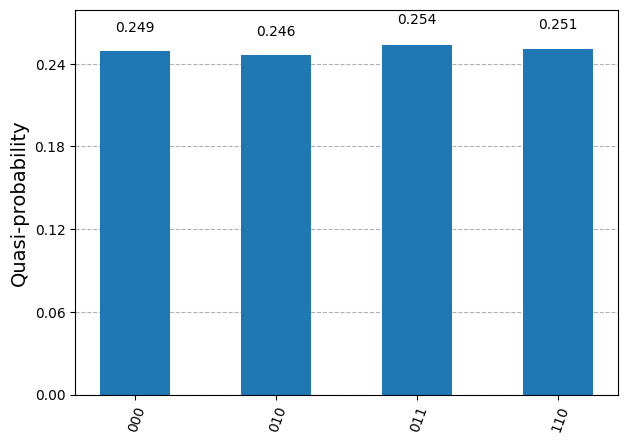

<IPython.core.display.Latex object>

In [90]:
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
compiled_circuit = pass_manager.run(qc)

# display decomposed state preparation circuit
display(compiled_circuit.decompose().decompose().decompose().draw(output='mpl'))

result = backend.run(compiled_circuit).result()
display(plot_distribution(result.get_counts()))

# Get the statevector
dist = result.get_counts()
state = np.zeros(np.power(2, len(q)))
for key in dist:
    state[int(key, 2)] = dist[key]
state /= np.linalg.norm(state)

# display the state vector in a pretty way
from qiskit.visualization import array_to_latex
array_to_latex(state, prefix="\\text{Statevector} = ")

## Angle Encoding

Angle encoding is a method of encoding classical data into a quantum state by setting the phase of the quantum state according to the classical data. This encoding method is more efficient than basis encoding as it can encode multiple classical states into a single quantum state. To be more specific, the angle encoding of a classical state $x$ is given by the quantum state $\sum_{i} \alpha_i \ket{i}$, where $\alpha_i$ is the phase of the state $\ket{i}$.

In [91]:
def angle_encoder(qc: QuantumCircuit, q: QuantumRegister, angles: np.ndarray):
    # normalize the angles
    angles = np.array(angles) / np.linalg.norm(angles) * np.pi
    for i in range(len(angles)):
        qc.ry(angles[i], q[i])

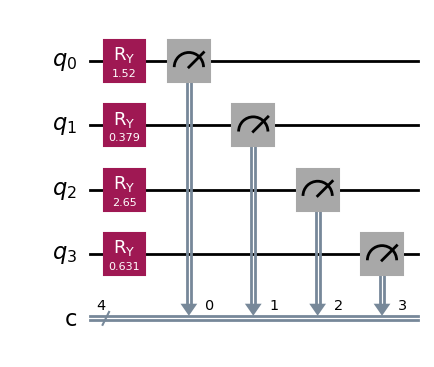

In [92]:
angles = np.array([1.2, 0.3, 2.1, 0.5])
n = len(angles)
q = QuantumRegister(n, 'q')
c = ClassicalRegister(n, 'c')

qc = QuantumCircuit(q, c)
angle_encoder(qc, q, angles)

qc.measure(q, c)
qc.draw(output='mpl')

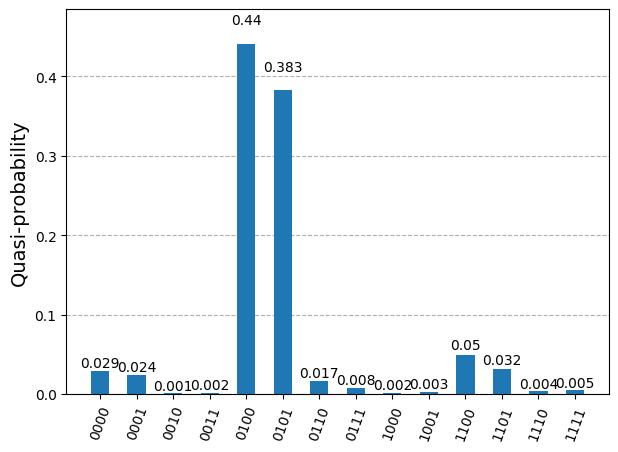

In [93]:
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
compiled_circuit = pass_manager.run(qc)

result = backend.run(compiled_circuit).result()
plot_distribution(result.get_counts())

# Post processing to recover the angles